In [53]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import scipy
import numpy as np
import pandas as pd

from pathlib import Path
import soundfile as sf
from tqdm import tqdm
from sklearn.cluster import KMeans

In [54]:
import sys

# append the path of the
# parent directory
sys.path.append('..')
sys.path.append('../src/')
sys.path.append('../src/models/bat_call_detector/batdetect2/')

import src.batdt2_pipeline as batdetect2_pipeline
from pipeline import pipeline
from cfg import get_config

In [55]:
def collect_channels(filepath, samplingrate, offset, duration_in_secs):
    channels = [[], [], [], [], [], [], [], []]

    with open(filepath, "rb") as rawFile:

        rawFile.seek(int(2*8*samplingrate*offset), 0)
        for i in range(samplingrate*duration_in_secs):
            for j in range(8):
                bytes = rawFile.read(2)
                sample_int = int.from_bytes(bytes = bytes, byteorder = "little", signed = True)
                sample_float = sample_int * (5 / 32768)

                channels[j].append(sample_float)

    return np.array(channels)

In [56]:
def plot_audio_seg_spec(audio_features, spec_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 18})
    plt.title(f"Spectrogram of {audio_features['plot_title']}", fontsize=24)
    plt.specgram(audio_seg+1e-6, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax, mode='magnitude', scale='dB')
    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.colorbar()
    plt.show()

def plot_audio_seg_signal(audio_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 18})
    plt.title(f"Signal of {audio_features['plot_title']}", fontsize=24)
    plt.plot(audio_seg)
    plot_xtype = 'float'
    plt.xlim(0, duration*fs)
    plt.ylim(-5, 5)
    plt.grid(which='both')
    plt.xticks(ticks=np.linspace(0, audio_features['duration']*fs, 11), 
                labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Voltage (V)")
    plt.xlabel("Time (s)")
    plt.show()

def plot_audio_seg_fft(audio_features):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 18})
    plt.title(f"FFT of {audio_features['plot_title']}", fontsize=24)
    abs_sig = np.abs(scipy.fft.rfft(audio_seg, n=len(audio_seg)))
    abs_sig = abs_sig / len(abs_sig)
    plt.plot(20*np.log10(abs_sig/np.max(abs_sig)))
    plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, len(abs_sig), 11), 
                labels=np.round(np.linspace(0, (fs/2), 11, dtype=plot_xtype), 2)/1e3, rotation=30)
    plt.ylabel("Voltage (dB)")
    plt.xlabel("Frequency (kHz)")
    plt.grid(which='both')
    plt.show()
    
FREQ_COLORS = {'LF':'cyan',
               'HF':'orange'}

def plot_colored_dets_over_audio(audio_features, spec_features, plot_dets):
    audio_seg = audio_features['audio_seg']
    fs = audio_features['sample_rate']
    start = audio_features['start']
    duration = audio_features['duration']

    vmax = spec_features['vmax']
    vmin = spec_features['vmin']
    cmap = spec_features['cmap']
    nfft = spec_features['NFFT']

    plt.figure(figsize=(15, 5))
    plt.rcParams.update({'font.size': 24})
    plt.title(f"Spectrogram of {audio_features['plot_title']}", fontsize=24)
    plt.specgram(audio_seg, NFFT=nfft, cmap=cmap, vmin=vmin, vmax=vmax, mode='magnitude', scale='dB')

    ax = plt.gca()
    for i, row in plot_dets.iterrows():
        rect = patches.Rectangle(((row['start_time'] - start)*(fs/2), row['low_freq']/(fs/2)), 
                        (row['end_time'] - row['start_time'])*(fs/2), (row['high_freq'] - row['low_freq'])/(fs/2), 
                        linewidth=2, edgecolor=FREQ_COLORS[row['KMEANS_CLASSES']], facecolor='none', alpha=0.8)
        ax.add_patch(rect)

    plt.yticks(ticks=np.linspace(0, 1, 6), labels=np.linspace(0, fs/2000, 6).astype('int'))
    plot_xtype = 'float'
    if (duration > 60):
        plot_xtype = 'int'
    plt.xticks(ticks=np.linspace(0, duration*(fs/2), 11), 
               labels=np.round(np.linspace(start, start+duration, 11, dtype=plot_xtype), 2), rotation=30)
    plt.ylabel("Frequency (kHz)")
    plt.xlabel("Time (s)")
    plt.show()

In [59]:
fs = 250000
file_dir = Path('/Volumes/Elements/UBNA_array_tests/adc_test_inlab_20240910')
filepath = file_dir / 'hour_0.raw'

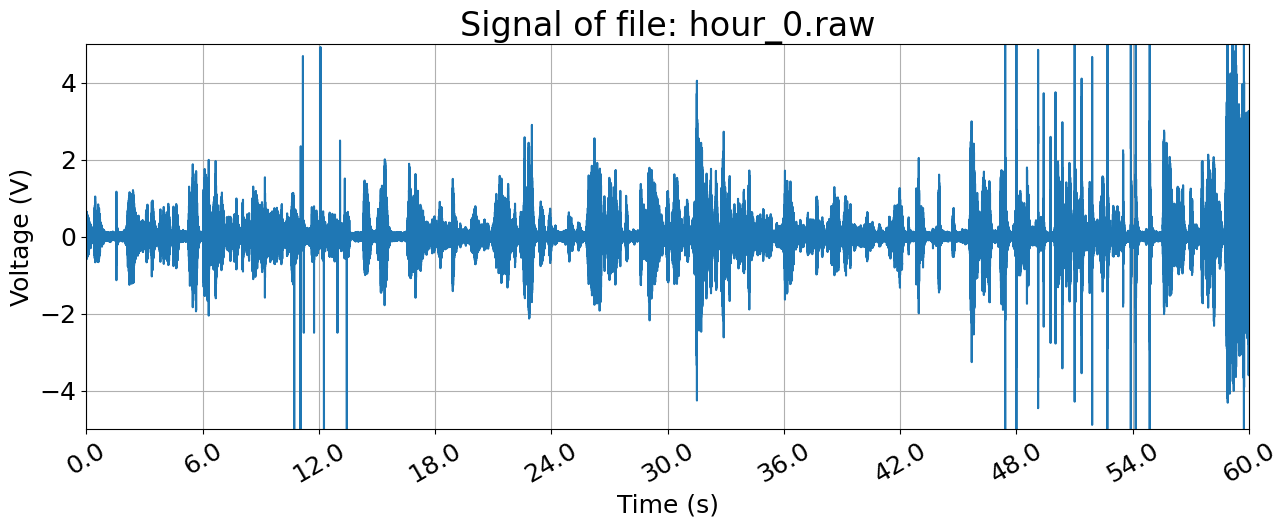

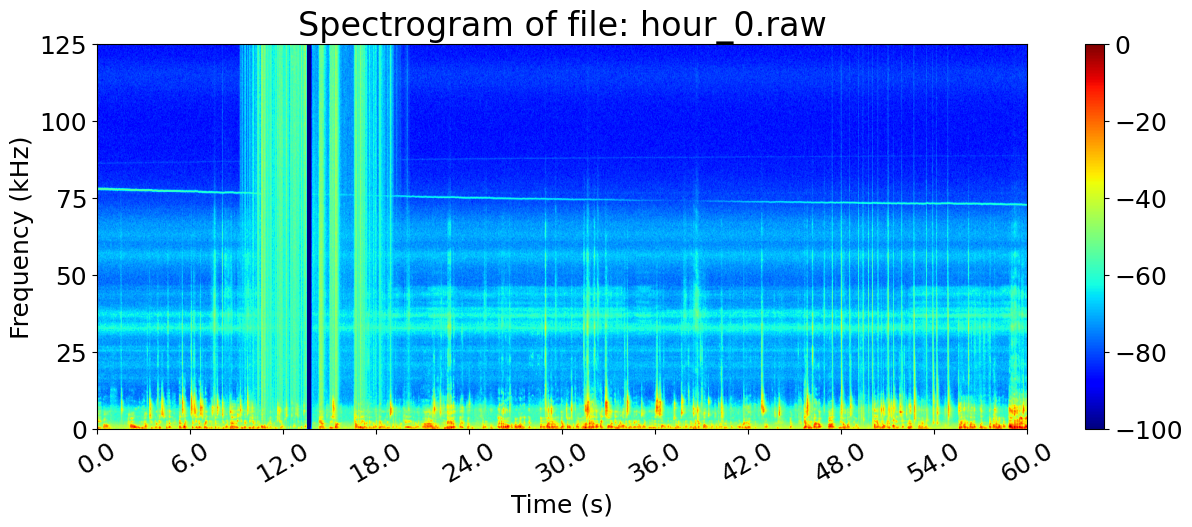

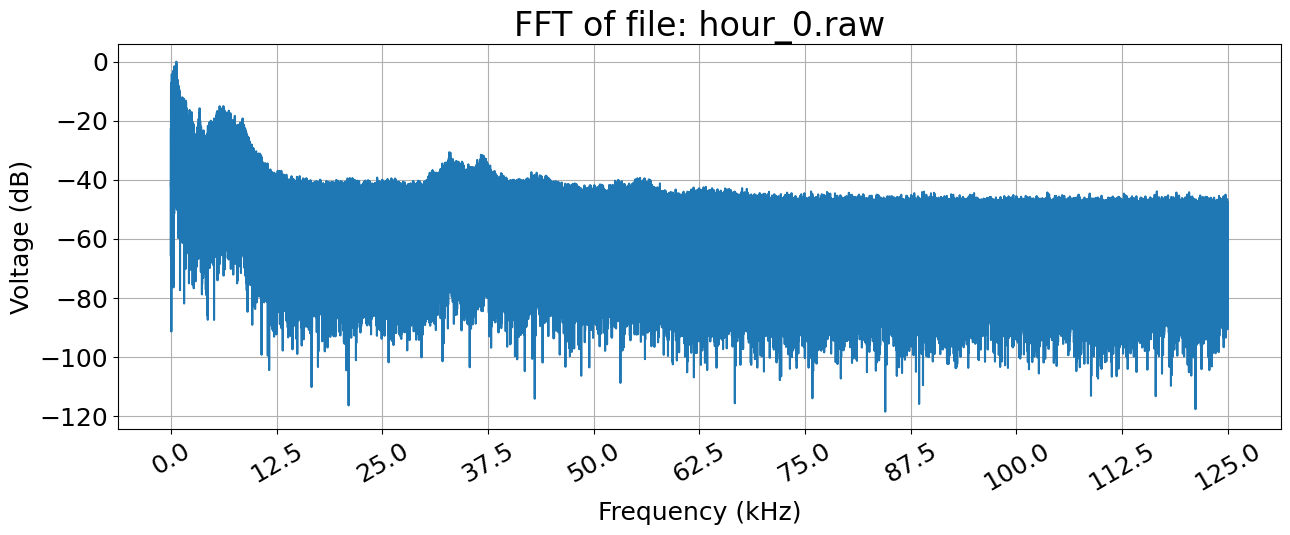

In [60]:
offset = 0
duration_in_secs = 60
channels = collect_channels(filepath, fs, offset, duration_in_secs)
audio_seg = channels[0]
vmax = 0
vmin = -100

audio_features = dict()
audio_features['file_path'] = filepath
audio_features['audio_seg'] = audio_seg
audio_features['sample_rate'] = fs
audio_features['start'] = offset
audio_features['duration'] = duration_in_secs

spec_features = dict()
spec_features['NFFT'] = 1024 # When segments are short, NFFT should also be small to best see calls (must always be > 128)
spec_features['cmap'] = 'jet' # This colormap shows best contrast between noise and signals
spec_features['vmin'] = vmin
spec_features['vmax'] = vmax

audio_features['plot_title'] = f"file: {audio_features['file_path'].name}"
plot_audio_seg_signal(audio_features)
plot_audio_seg_spec(audio_features, spec_features)
plot_audio_seg_fft(audio_features)